# Example
#### Model: MLP
#### Data: MNIST (0,7) classes
#### 10% switch labels rate

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import pytorch_lightning as pl

class BinaryMNISTClassifier(pl.LightningModule):
    def __init__(self, input_size=28*28, hidden_sizes=[128,32], output_size=1, learning_rate=1e-3, dropout_rate=0.7):
        super(BinaryMNISTClassifier, self).__init__()
        self.learning_rate = learning_rate
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)  # Adjust shape for BCELoss
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        
        # Calculate accuracy
        preds = (logits > 0.5).float()
        accuracy = (preds == y).float().mean()
        
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)
        return {"test_loss": loss, "test_accuracy": accuracy}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [7]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from torchmetrics.classification import Accuracy

class CNNBinaryMNISTClassifier(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, dropout_rate=0.5):
        super(CNNBinaryMNISTClassifier, self).__init__()
        self.learning_rate = learning_rate
        
        # Define the CNN architecture using nn.Sequential
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  # (28, 28) -> (28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (28, 28) -> (28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (28, 28) -> (14, 14)
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # (14, 14) -> (14, 14)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (14, 14) -> (14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (14, 14) -> (7, 7)
            
            nn.Flatten(),  # Flatten the output for the fully connected layers
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),  # Single output for binary classification
            nn.Sigmoid()  # Apply sigmoid to get output between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)  # Adjust shape for BCELoss
        logits = self(x)
        loss = nn.BCELoss()(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)  # Adjust shape for BCELoss
        logits = self(x)
        loss = nn.BCELoss()(logits, y)
        
        # Calculate accuracy
        preds = (logits > 0.5).float()  # Threshold logits at 0.5 to make binary predictions
        accuracy = (preds == y).float().mean()

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)
        return {"test_loss": loss, "test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [8]:
def create_binary_subset(dataset, label1, label2):
    # Filter for the two specified labels
    idx = (dataset.targets == label1) | (dataset.targets == label2)
    binary_subset = Subset(dataset, torch.where(idx)[0])
    
    # Map label1 to 0 and label2 to 1
    mapped_targets = torch.tensor([0 if label == label1 else 1 for label in dataset.targets[idx]])
    
    # Update dataset targets to reflect the binary mapping
    for i, original_idx in enumerate(torch.where(idx)[0]):
        binary_subset.dataset.targets[original_idx] = mapped_targets[i]
    
    return binary_subset



In [10]:
import torch
import random
import numpy as np
random.seed(42)

label1, label2 = 0, 7  # Choose any two labels here
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="../data/", train=True, transform=transform, download=True)

binary_mnist_train = create_binary_subset(mnist_train, label1, label2)

# Step 1: Retrieve data and labels
data = []
labels = []
for img, label in binary_mnist_train:
    data.append(img)
    labels.append(label)

# Convert data and labels to tensors
data = torch.stack(data)  # shape: [num_samples, channels, height, width]
labels = torch.tensor(labels, dtype=torch.long)

# Step 2: Generate fake labels by switching 5% of them
fake_labels = labels.clone()  # Copy true labels
num_samples = len(labels)
num_switch = int(0.2 * num_samples)  # 20% of labels to switch
# indices_to_switch = random.sample(range(num_samples), num_switch)
indices_to_switch = random.sample(np.where(labels==1)[0].tolist(), num_switch)

# for idx in indices_to_switch:
#     fake_labels[idx] = label2 if fake_labels[idx] == label1 else label1
for idx in indices_to_switch:
    fake_labels[idx] = (fake_labels[idx] +1)%2
    
# Convert data and fake labels to tensors
data = data.float()  # Convert data to float32 tensor if needed
fake_labels = fake_labels.long()  # Convert fake_labels to long tensor


In [16]:
from tml.pipeline import Pipeline, ModelHandler
from tml.analysis import BinaryClassificationAnalysis


In [17]:

# model_instance = BinaryMNISTClassifier()
model_instance = CNNBinaryMNISTClassifier(dropout_rate=0.7, learning_rate=1.0e-4)

In [18]:
# Initialize the pipeline
model_handler = ModelHandler(model_instance=model_instance)
pipeline = Pipeline(model_handler, data=data, hard_targets=fake_labels, max_epochs=40, drop_iterations=100)

In [ ]:
pipeline.run(n_steps=25)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 503 K  | train
---------------------------------------------
503 K     Trainable params
0         Non-trainable params
503 K     Total params
2.016     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Seed: 42
Level 1 init: subset 43
Level 1 training: subset 43
Epoch 34:  58%|█████▊    | 70/120 [00:00<00:00, 180.17it/s, v_num=27, train_loss=0.338] 

In [20]:
torch.unique(fake_labels)

tensor([0, 1])

In [21]:
(labels == fake_labels).sum()

tensor(9751)

In [22]:
len(labels)

12188

ROC AUC: 0.9055958081474705, Brier Score: 0.18032222609816634


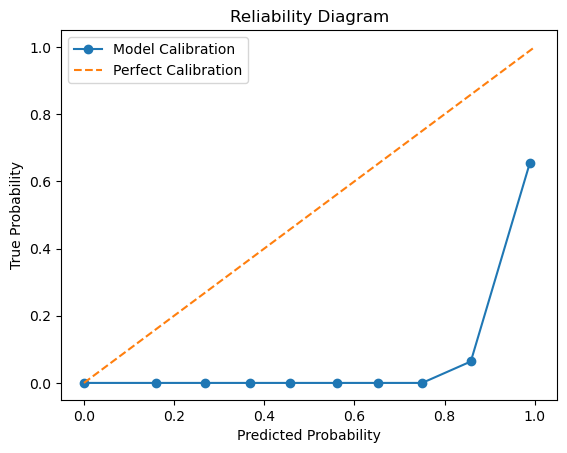

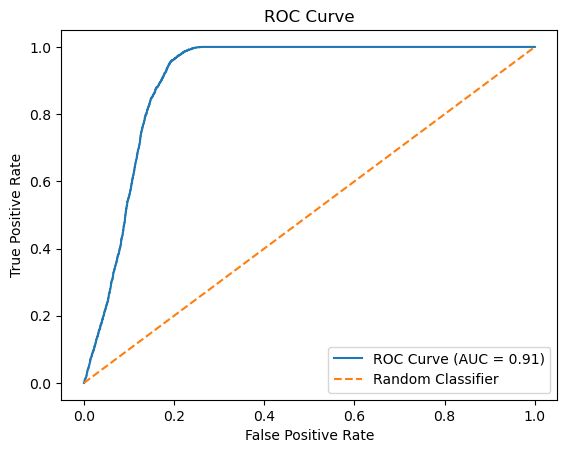

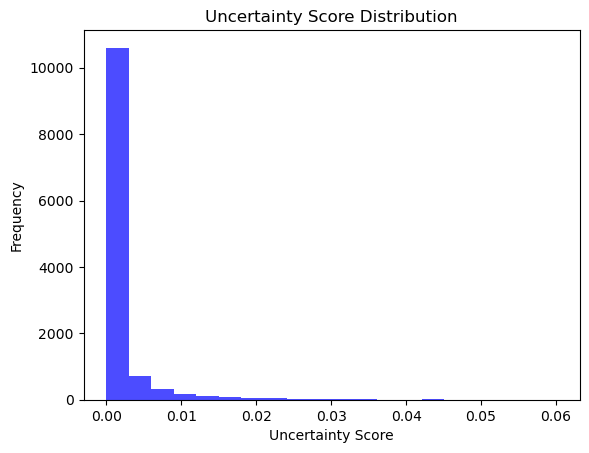

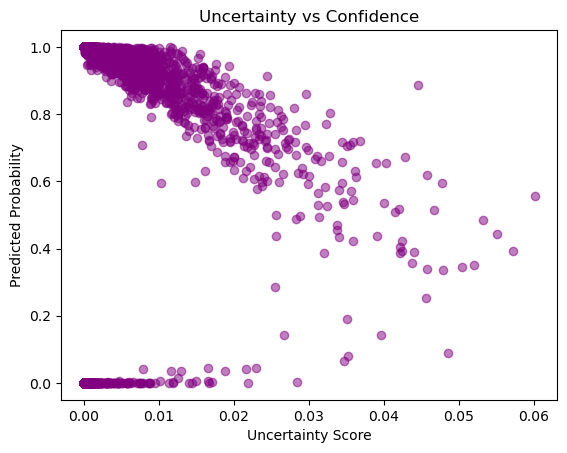

In [23]:
# Assuming labels, probability_scores, and uncertainty_scores are available
analysis = BinaryClassificationAnalysis(pipeline.hard_targets.cpu().numpy(),
                                        pipeline.probability_scores,
                                        pipeline.uncertainty_scores)

# Calculate metrics
roc_auc = analysis.calculate_roc_auc()
brier_score = analysis.calculate_brier_score()
print(f"ROC AUC: {roc_auc}, Brier Score: {brier_score}")

# Plotting
analysis.plot_reliability_diagram()
analysis.plot_roc_curve()
analysis.plot_uncertainty_distribution()
analysis.plot_uncertainty_vs_confidence()


In [24]:
import pandas as pd

# Assuming the variables labels, fake_labels, probability_scores, and uncertainty_scores are already defined

# Convert each to a list or numpy array if they aren't already in those formats
labels = labels.cpu().numpy() if torch.is_tensor(labels) else labels
fake_labels = fake_labels.cpu().numpy() if torch.is_tensor(fake_labels) else fake_labels
probability_scores = pipeline.probability_scores
uncertainty_scores = pipeline.uncertainty_scores
confidence_adjusted_scores = (1 - probability_scores) * uncertainty_scores

# Ensure that all components have the same length
assert len(labels) == len(fake_labels) == len(probability_scores) == len(uncertainty_scores), "Mismatched lengths"

# Create the DataFrame
df = pd.DataFrame({
    'labels': labels,
    'fake_labels': fake_labels,
    'probability_scores': probability_scores,
    'uncertainty_scores': uncertainty_scores,
    'confidence_adjusted_scores': confidence_adjusted_scores,
    'label_issue': (labels+fake_labels)%2
})

# Display the DataFrame
df.head()


,labels,fake_labels,probability_scores,uncertainty_scores,confidence_adjusted_scores,label_issue
0,0,0,2.182494e-21,7.163676e-09,7.163676e-09,0
1,1,1,9.974081e-01,1.354426e-03,3.510481e-06,0
2,0,0,8.851457e-19,5.511817e-12,5.511817e-12,0
3,1,1,9.842063e-01,2.117820e-03,3.344818e-05,0
4,0,0,1.011282e-09,4.755325e-05,4.755325e-05,0


In [27]:
df.sort_values('confidence_adjusted_scores')[-1000:]['label_issue'].sum()

np.int64(592)

In [28]:
# Assuming your DataFrame is named df and has 'predicted_probability' and 'uncertainty_score' columns

# Set thresholds
uncertainty_threshold = 0.01  # Adjust based on your data
high_confidence_threshold = 0.90
low_confidence_threshold = 0.1

# Identify noisy labels
df['high_uncert'] = (df['uncertainty_scores'] > uncertainty_threshold)
df['low_conf'] = ((df['probability_scores'] > low_confidence_threshold) & (df['probability_scores'] < high_confidence_threshold))

# Filter to see only noisy samples
# noisy_labels_df = df[df['is_noisy']]

# # Output or examine noisy labels
# print(noisy_labels_df)


In [29]:
df_conf = df[~df['low_conf']]

In [30]:
sum(df['labels'] != df['fake_labels'])

2437

In [31]:
df_conf

,labels,fake_labels,probability_scores,uncertainty_scores,confidence_adjusted_scores,label_issue,high_uncert,low_conf
0,0,0,2.182494e-21,7.163676e-09,7.163676e-09,0,False,False
1,1,1,9.974081e-01,1.354426e-03,3.510481e-06,0,False,False
2,0,0,8.851457e-19,5.511817e-12,5.511817e-12,0,False,False
3,1,1,9.842063e-01,2.117820e-03,3.344818e-05,0,False,False
4,0,0,1.011282e-09,4.755325e-05,4.755325e-05,0,False,False
...,...,...,...,...,...,...,...,...
12183,1,1,9.993153e-01,3.976261e-04,2.722385e-07,0,False,False
12184,0,0,8.471793e-15,3.068728e-09,3.068728e-09,0,False,False
12185,1,1,9.999458e-01,7.316794e-05,3.966029e-09,0,False,False
12186,0,0,2.283311e-20,2.346372e-08,2.346372e-08,0,False,False


In [32]:
from tml.plotting import tml_plots
import os
import numpy as np

label_type = (labels == fake_labels)

### Extra plots and metrics

In [33]:
df_cert = df[~df['high_uncert']]

In [34]:
df_cert_conf = df_cert[~df_cert['low_conf']]

In [35]:
print(sum(df_cert_conf['labels']== df_cert_conf['fake_labels']) / df_cert_conf.shape[0])
print(sum(df_cert['labels']== df_cert['fake_labels']) / df_cert.shape[0])
print(sum(df_conf['labels']== df_conf['fake_labels']) / df_conf.shape[0])

0.8286376911183645
0.823153045555366
0.8278061224489796


In [204]:
sum(labels == fake_labels) / labels.shape[0]

np.float64(0.8000492287495897)

In [205]:
out_path = 'results'
sample_name = 'mnist_0_1'
pscore_cf = 0.1
auc_cf = 0.9
tpr_cf = 0.95

pos_ind = np.where(fake_labels == 1)[0]
neg_ind = np.where(fake_labels == 0)[0]

final = np.column_stack((pipeline.probability_scores, pipeline.uncertainty_scores))


# Plot and calculate thresholds
os.makedirs(out_path, exist_ok=True)


thr = tml_plots(final,
                neg_ind,
                pos_ind,
                pscore_cf,
                auc_cf,
                tpr_cf,
                f"{out_path}/{sample_name}"
                )

final = np.column_stack((final, np.repeat("PASS", len(pipeline.uncertainty_scores))))
final[final[:,1].astype(float) > thr, 2] = "FAIL_Uncertain"
final[final[:,0].astype(float) <= pscore_cf, 2] = "FAIL_LowScore"

# final = np.column_stack((final, np.repeat(1, len(pipeline.uncertainty_scores))))
# final[final[:,1].astype(float) > thr, 2] = 0 #"FAIL_Uncertain"
# final[final[:,0].astype(float) <= pscore_cf, 2] = 0 # "FAIL_LowScore"

final = np.column_stack((label_type, final))
# final = np.column_stack((labels, final))
final_df = pd.DataFrame(final, columns=['true_label_or_not', 'Probability_Score', 'Uncertainty_Score', 'Result'])
# save = np.column_stack((names, final))
# header = ['Mutation', 'Type', 'Probability_Score', 'Uncertainty_Score', 'Result']
# pd.DataFrame(save.astype(str)).to_csv(f"{out_path}/{sample_name}_scores.csv", header=header, index=None)
thr

np.float64(0.004999999999999782)

In [206]:
confidence_adjusted_score

array([2.60668409e-05, 2.33212975e-07, 5.35430105e-06, ...,
       6.75959279e-03, 8.35189763e-08, 0.00000000e+00])

In [207]:
df

,labels,fake_labels,probability_scores,uncertainty_scores,confidence_adjusted_scores,label_issue,high_uncert,low_conf
0,0,0,8.262042e-19,1.168010e-15,1.168010e-15,0,False,False
1,1,1,9.999810e-01,3.770837e-05,7.169825e-10,0,False,False
2,0,0,6.724625e-21,4.811537e-13,4.811537e-13,0,False,False
3,1,1,9.999785e-01,5.536017e-05,1.187900e-09,0,False,False
4,0,0,4.018435e-13,5.082252e-06,5.082252e-06,0,False,False
...,...,...,...,...,...,...,...,...
12183,1,1,1.000000e+00,2.752934e-07,0.000000e+00,0,False,False
12184,0,0,1.201842e-15,1.003143e-10,1.003143e-10,0,False,False
12185,1,1,1.000000e+00,3.744260e-08,0.000000e+00,0,False,False
12186,0,0,8.395036e-18,1.080943e-10,1.080943e-10,0,False,False


In [208]:
# print(final_df['Result'].sum())
# print(final_df['true_label_or_not'].sum())
final_df

,true_label_or_not,Probability_Score,Uncertainty_Score,Result
0,True,8.262042292374897e-19,1.1680095181153958e-15,FAIL_LowScore
1,True,0.9999809861183167,3.770837065545152e-05,PASS
2,True,6.7246253742673595e-21,4.811536911086539e-13,FAIL_LowScore
3,True,0.9999785423278809,5.5360172893870185e-05,PASS
4,True,4.0184350020477994e-13,5.08225223993066e-06,FAIL_LowScore
...,...,...,...,...
12183,True,1.0,2.7529335078213535e-07,PASS
12184,True,1.2018421316079818e-15,1.003142874387067e-10,FAIL_LowScore
12185,True,1.0,3.7442597466963434e-08,PASS
12186,True,8.395036184475677e-18,1.0809431825216435e-10,FAIL_LowScore


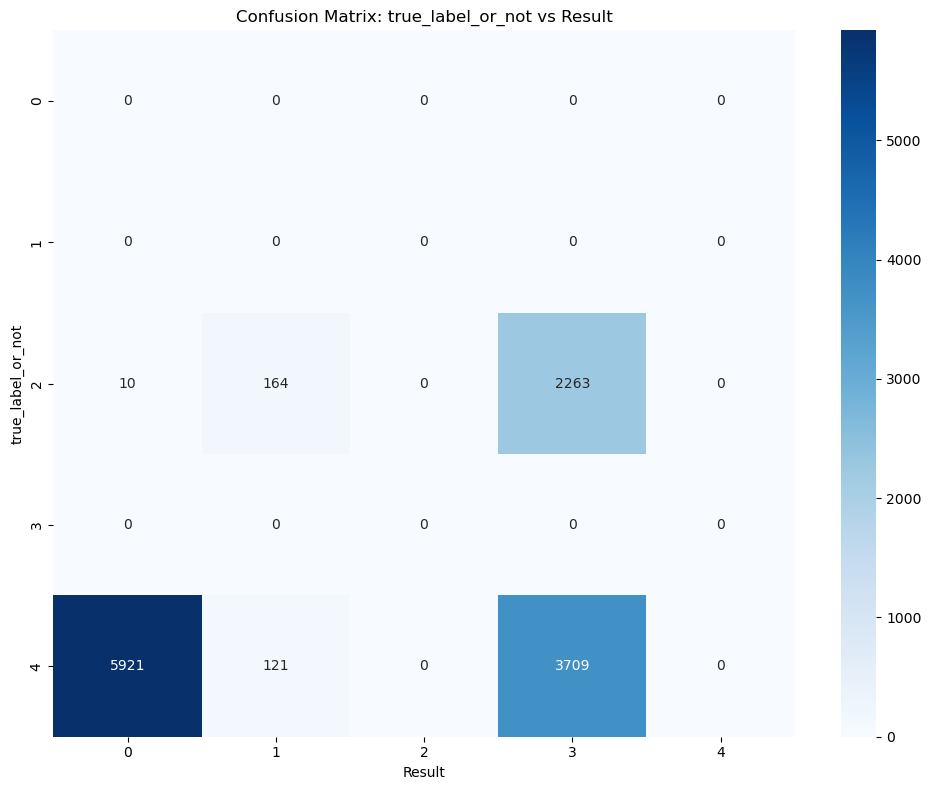

In [209]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create the confusion matrix
# cm = confusion_matrix(labels, fake_labels)
cm = confusion_matrix(final_df['true_label_or_not'], final_df['Result'])

# # Get unique labels (sorted to ensure consistent order)
# labels = sorted(set(df['torch_Result'].unique()) | set(df['tf_Result'].unique()))

# Create a DataFrame for better labeling
cm_df = pd.DataFrame(cm)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix: true_label_or_not vs Result')
plt.ylabel('true_label_or_not')
plt.xlabel('Result')

plt.tight_layout()
plt.show()

In [50]:
pd.DataFrame(final)

,0,1,2
0,8.387348701006659e-06,1.2232086308250843e-08,FAIL_LowScore
1,0.9999599242210389,1.1726959658499032e-07,PASS
2,9.877120785084515e-07,2.610262283011096e-10,FAIL_LowScore
3,0.8914120054244995,0.002638387476331445,PASS
4,1.1175813570218906e-06,7.853789958439314e-10,FAIL_LowScore
...,...,...,...
12183,0.9999658107757569,2.949663296718946e-07,PASS
12184,1.1274932241889245e-05,1.4232550551286725e-08,FAIL_LowScore
12185,0.9983529376983643,8.375123980105315e-05,PASS
12186,3.445205039795951e-06,1.3616517492449215e-09,FAIL_LowScore
